In [38]:
import importlib
import retinanalysis as ra
importlib.reload(ra)
# importlib.reload(ra.analysis_chunk)
import pandas as pd
import numpy as np
ra.settings.mea_config
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Run below if needing to update the database
# ra.database_pop.reload_celltypefiles()
# ra.database_utils.populate_database()

In [10]:
import retinanalysis.dedup as dd
importlib.reload(dd)

<module 'retinanalysis.dedup' from '/Users/racheloaks-leaf/Desktop/retinanalysis/src/retinanalysis/dedup.py'>

In [2]:
df = ra.get_datasets_from_protocol_names('matfiles')
df


Found 1 protocols matching "matfiles":
['edu.washington.riekelab.protocols.PresentMatFiles']

Found 1 experiments, 1 epoch blocks.



exp_name datafile_name  NDF     chunk_name  \
0  20250514C       data003  0.5  movies_images   

                                       protocol_name  is_mea  \
0  edu.washington.riekelab.protocols.PresentMatFiles       1   

            data_dir      group_label  experiment_id  protocol_id  group_id  \
0  20250514C/data003  PresentMatFiles            125           74      2295   

   block_id  chunk_id  
0      3386       488

In [4]:
s1 = ra.StimBlock(df.at[0, 'exp_name'], df.at[0, 'datafile_name'])
ac1 = ra.AnalysisChunk(df.at[0, 'exp_name'], s1.nearest_noise_chunk)

Loading VCD from /Volumes/data/analysis/20250514C/chunk1/kilosort2.5 ...
VCD loaded with 781 cells.
Loaded spatial maps for channels [0, 2] and 781 cells of shape (127, 203, 2)
Spatial maps have been padded to align with RF parameters.


(127, 203, 2)

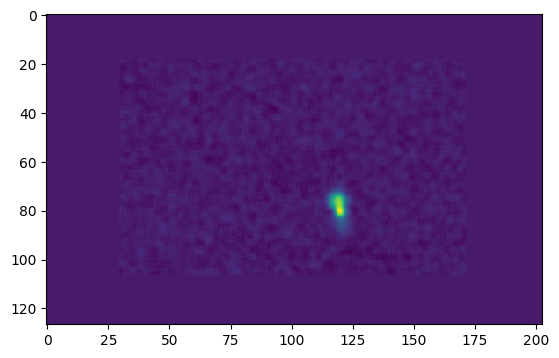

In [5]:
cell_idx = 10
cell_id = ac1.cell_ids[cell_idx]
display(ac1.d_spatial_maps[cell_id].shape)
plt.imshow(ac1.d_spatial_maps[cell_id][:,:,0])

Correlation matrix computation

In [6]:
sm_flat = [sm.flatten() for sm in ac1.d_spatial_maps.values()]
sm_flat = np.array(sm_flat)

ei_flat = [ac1.vcd.get_ei_for_cell(id).ei.flatten() for id in ac1.cell_ids]
ei_flat = np.array(ei_flat)

sm_corr = np.corrcoef(sm_flat)
ei_corr = np.corrcoef(ei_flat)

np.nan_to_num(sm_corr, copy=False, nan = 0, posinf = 0, neginf = 0)
np.nan_to_num(ei_corr, copy=False, nan = 0, posinf = 0, neginf = 0);

/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


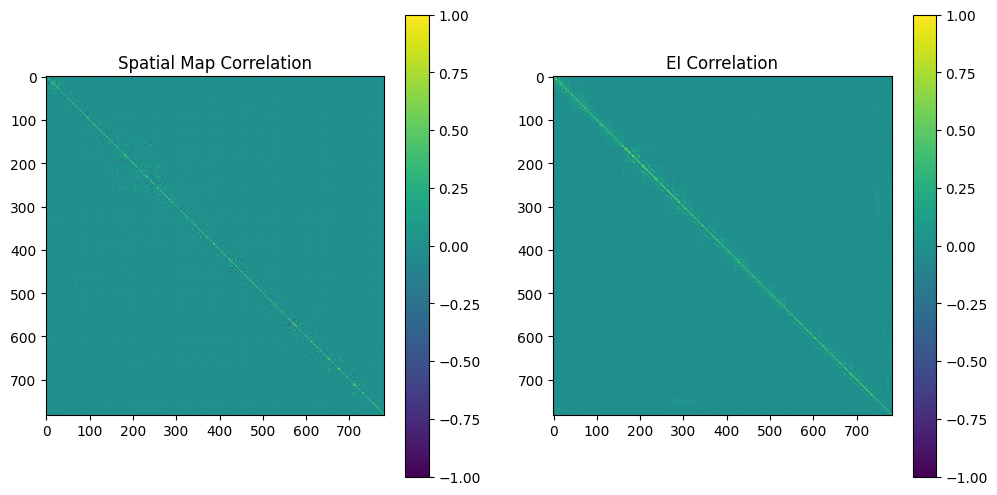

In [7]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
im = axs[0].imshow(sm_corr, cmap='viridis', vmin=-1, vmax=1)
axs[0].set_title('Spatial Map Correlation')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(ei_corr, cmap='viridis', vmin=-1, vmax=1)
axs[1].set_title('EI Correlation')
plt.colorbar(im, ax=axs[1])

In [3]:
#start with a noise file

df_1 = ra.get_datasets_from_protocol_names('.SpatialNoise')
df_1[df_1['exp_name'] == '20250514C']


Found 2 protocols matching ".spatialnoise":
['manookinlab.protocols.SpatialNoise'
 'manookinlab.protocols.SpatialNoiseAndMotion']

Found 45 experiments, 201 epoch blocks.



exp_name datafile_name  NDF chunk_name  \
177  20250514C       data000  0.5     chunk1   
178  20250514C       data001  0.5     chunk1   
179  20250514C       data006  0.5     chunk2   
180  20250514C       data010  0.5     chunk3   

                          protocol_name  is_mea           data_dir  \
177  manookinlab.protocols.SpatialNoise       1  20250514C/data000   
178  manookinlab.protocols.SpatialNoise       1  20250514C/data001   
179  manookinlab.protocols.SpatialNoise       1  20250514C/data006   
180  manookinlab.protocols.SpatialNoise       1  20250514C/data010   

             group_label  experiment_id  protocol_id  group_id  block_id  \
177        Spatial Noise            125           26      2293      3383   
178        Spatial Noise            125           26      2293      3384   
179  Spatial Noise 30 R*            125           26      2298      3389   
180       noise photopic            125           26      2302      3393   

     chunk_id  
177       485  
178       485  
179       486  
180       492

In [25]:
import retinanalysis.dedup as dd


<module 'retinanalysis.dedup' from '/Users/racheloaks-leaf/Desktop/retinanalysis/src/retinanalysis/dedup.py'>

In [4]:
sb = ra.StimBlock(df_1.at[177, 'exp_name'], df_1.at[177, 'datafile_name'])
ac = ra.AnalysisChunk(df_1.at[177, 'exp_name'], sb.nearest_noise_chunk)

Nearest noise chunk for data000 is chunk1 with distance 4 minutes.

Loading VCD from /Volumes/data/analysis/20250514C/chunk1/kilosort2.5 ...
VCD loaded with 781 cells.
Loaded spatial maps for channels [0, 2] and 781 cells of shape (127, 203, 2)
Spatial maps have been padded to align with RF parameters.


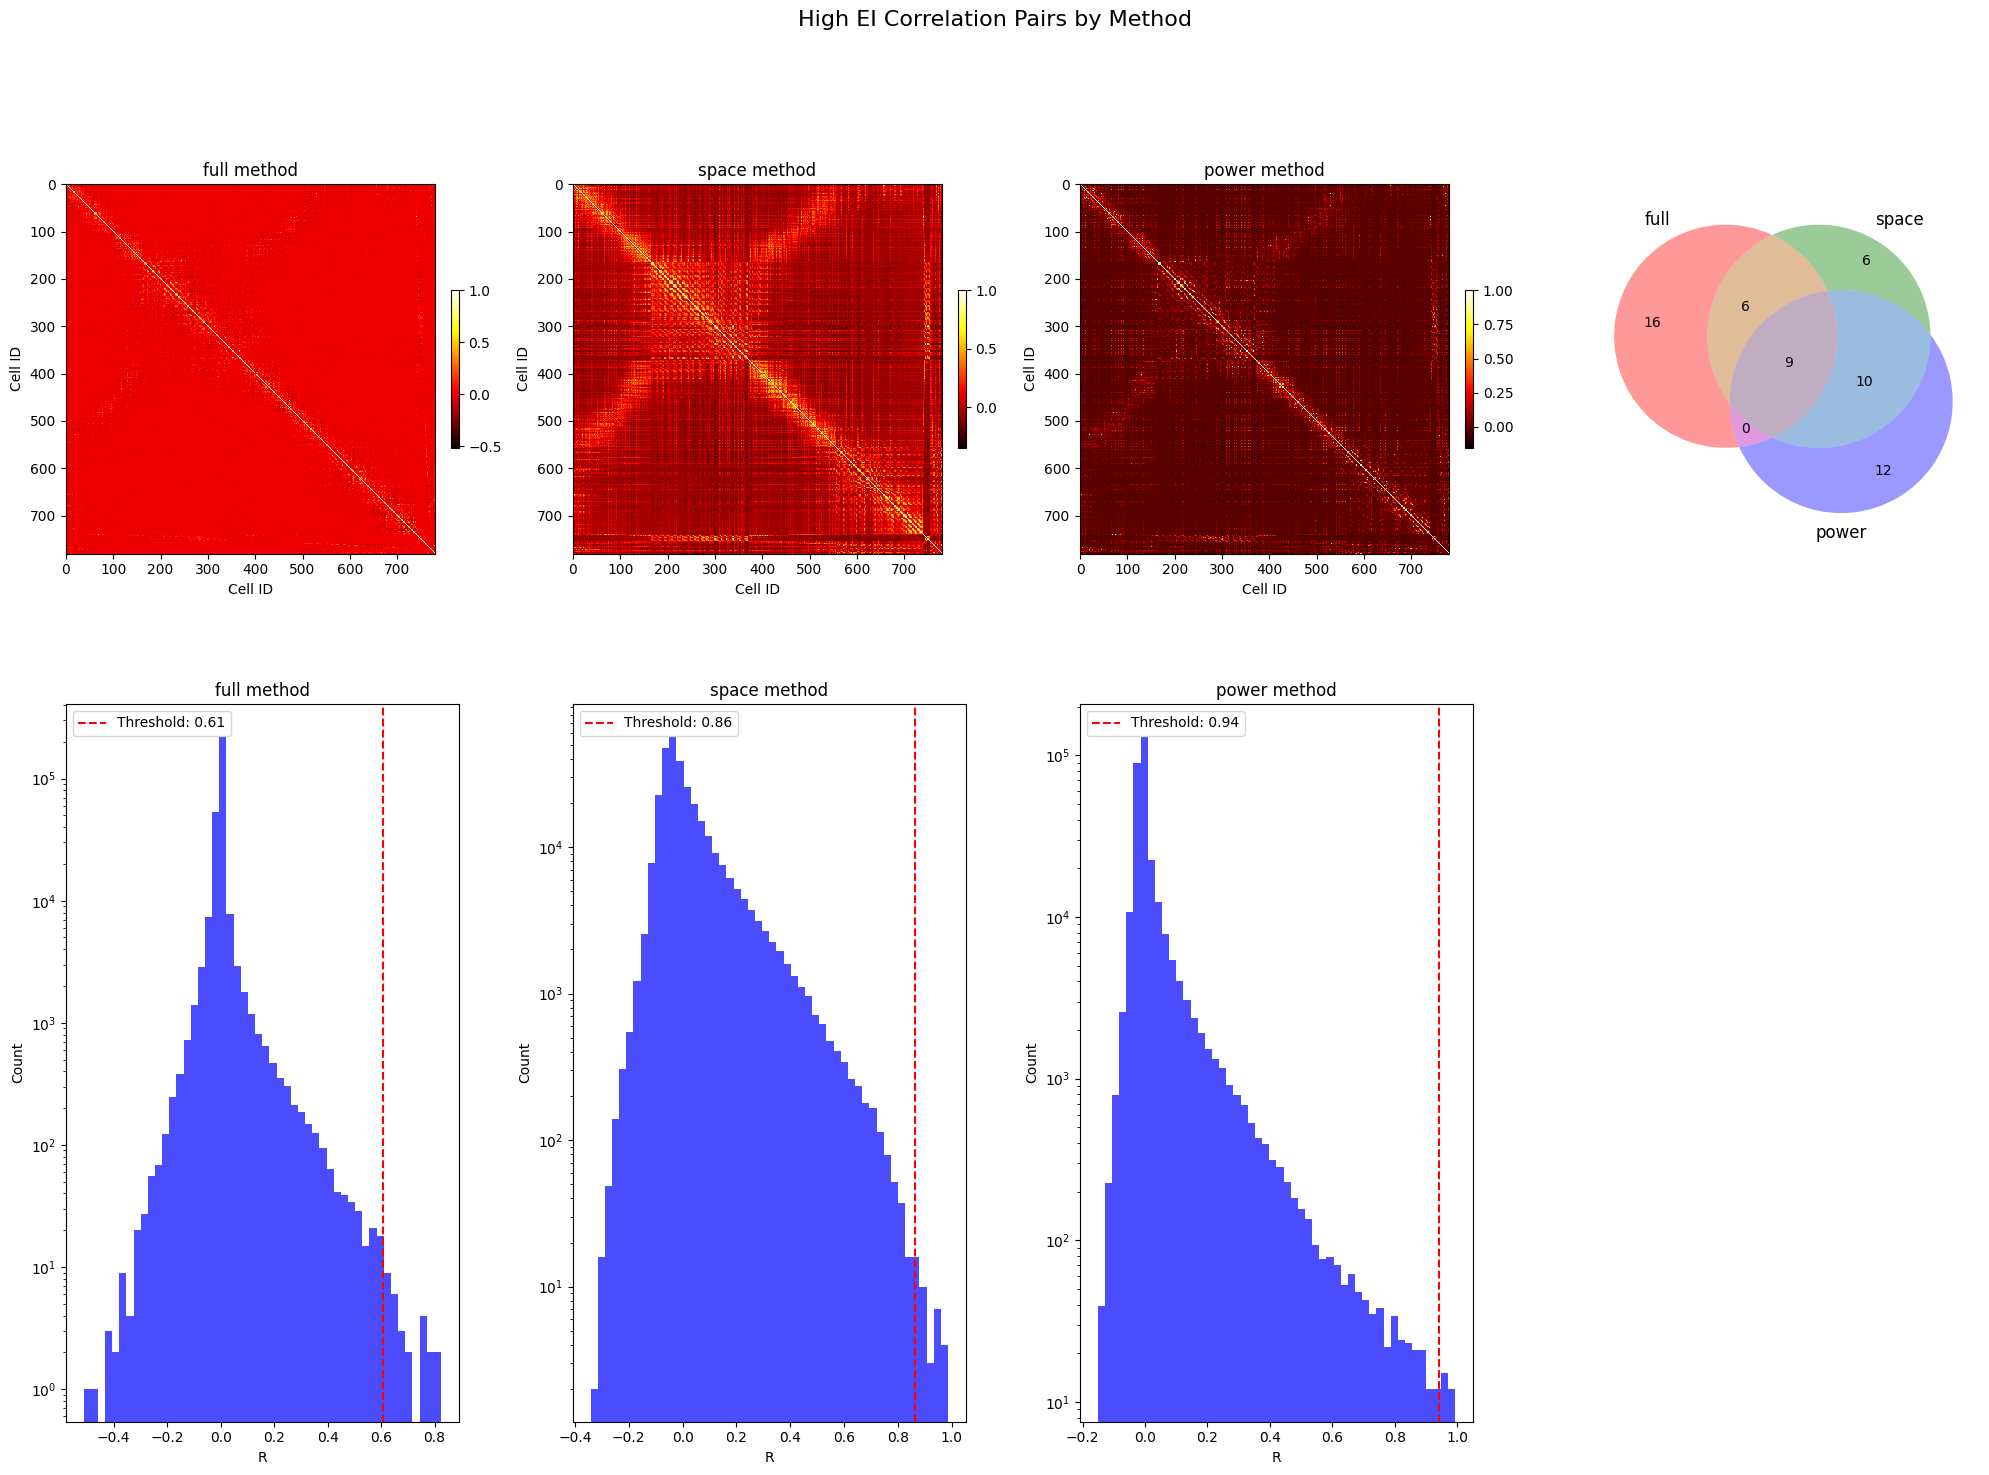

In [41]:
importlib.reload(dd)
dd.compare_ei_methods(ac);

In [ ]:
dup = dd.DedupBlock(exp_name=ac.exp_name, chunk_name=ac.chunk_name, ss_version='kilosort2.5', is_noise=True, ei_method='space')

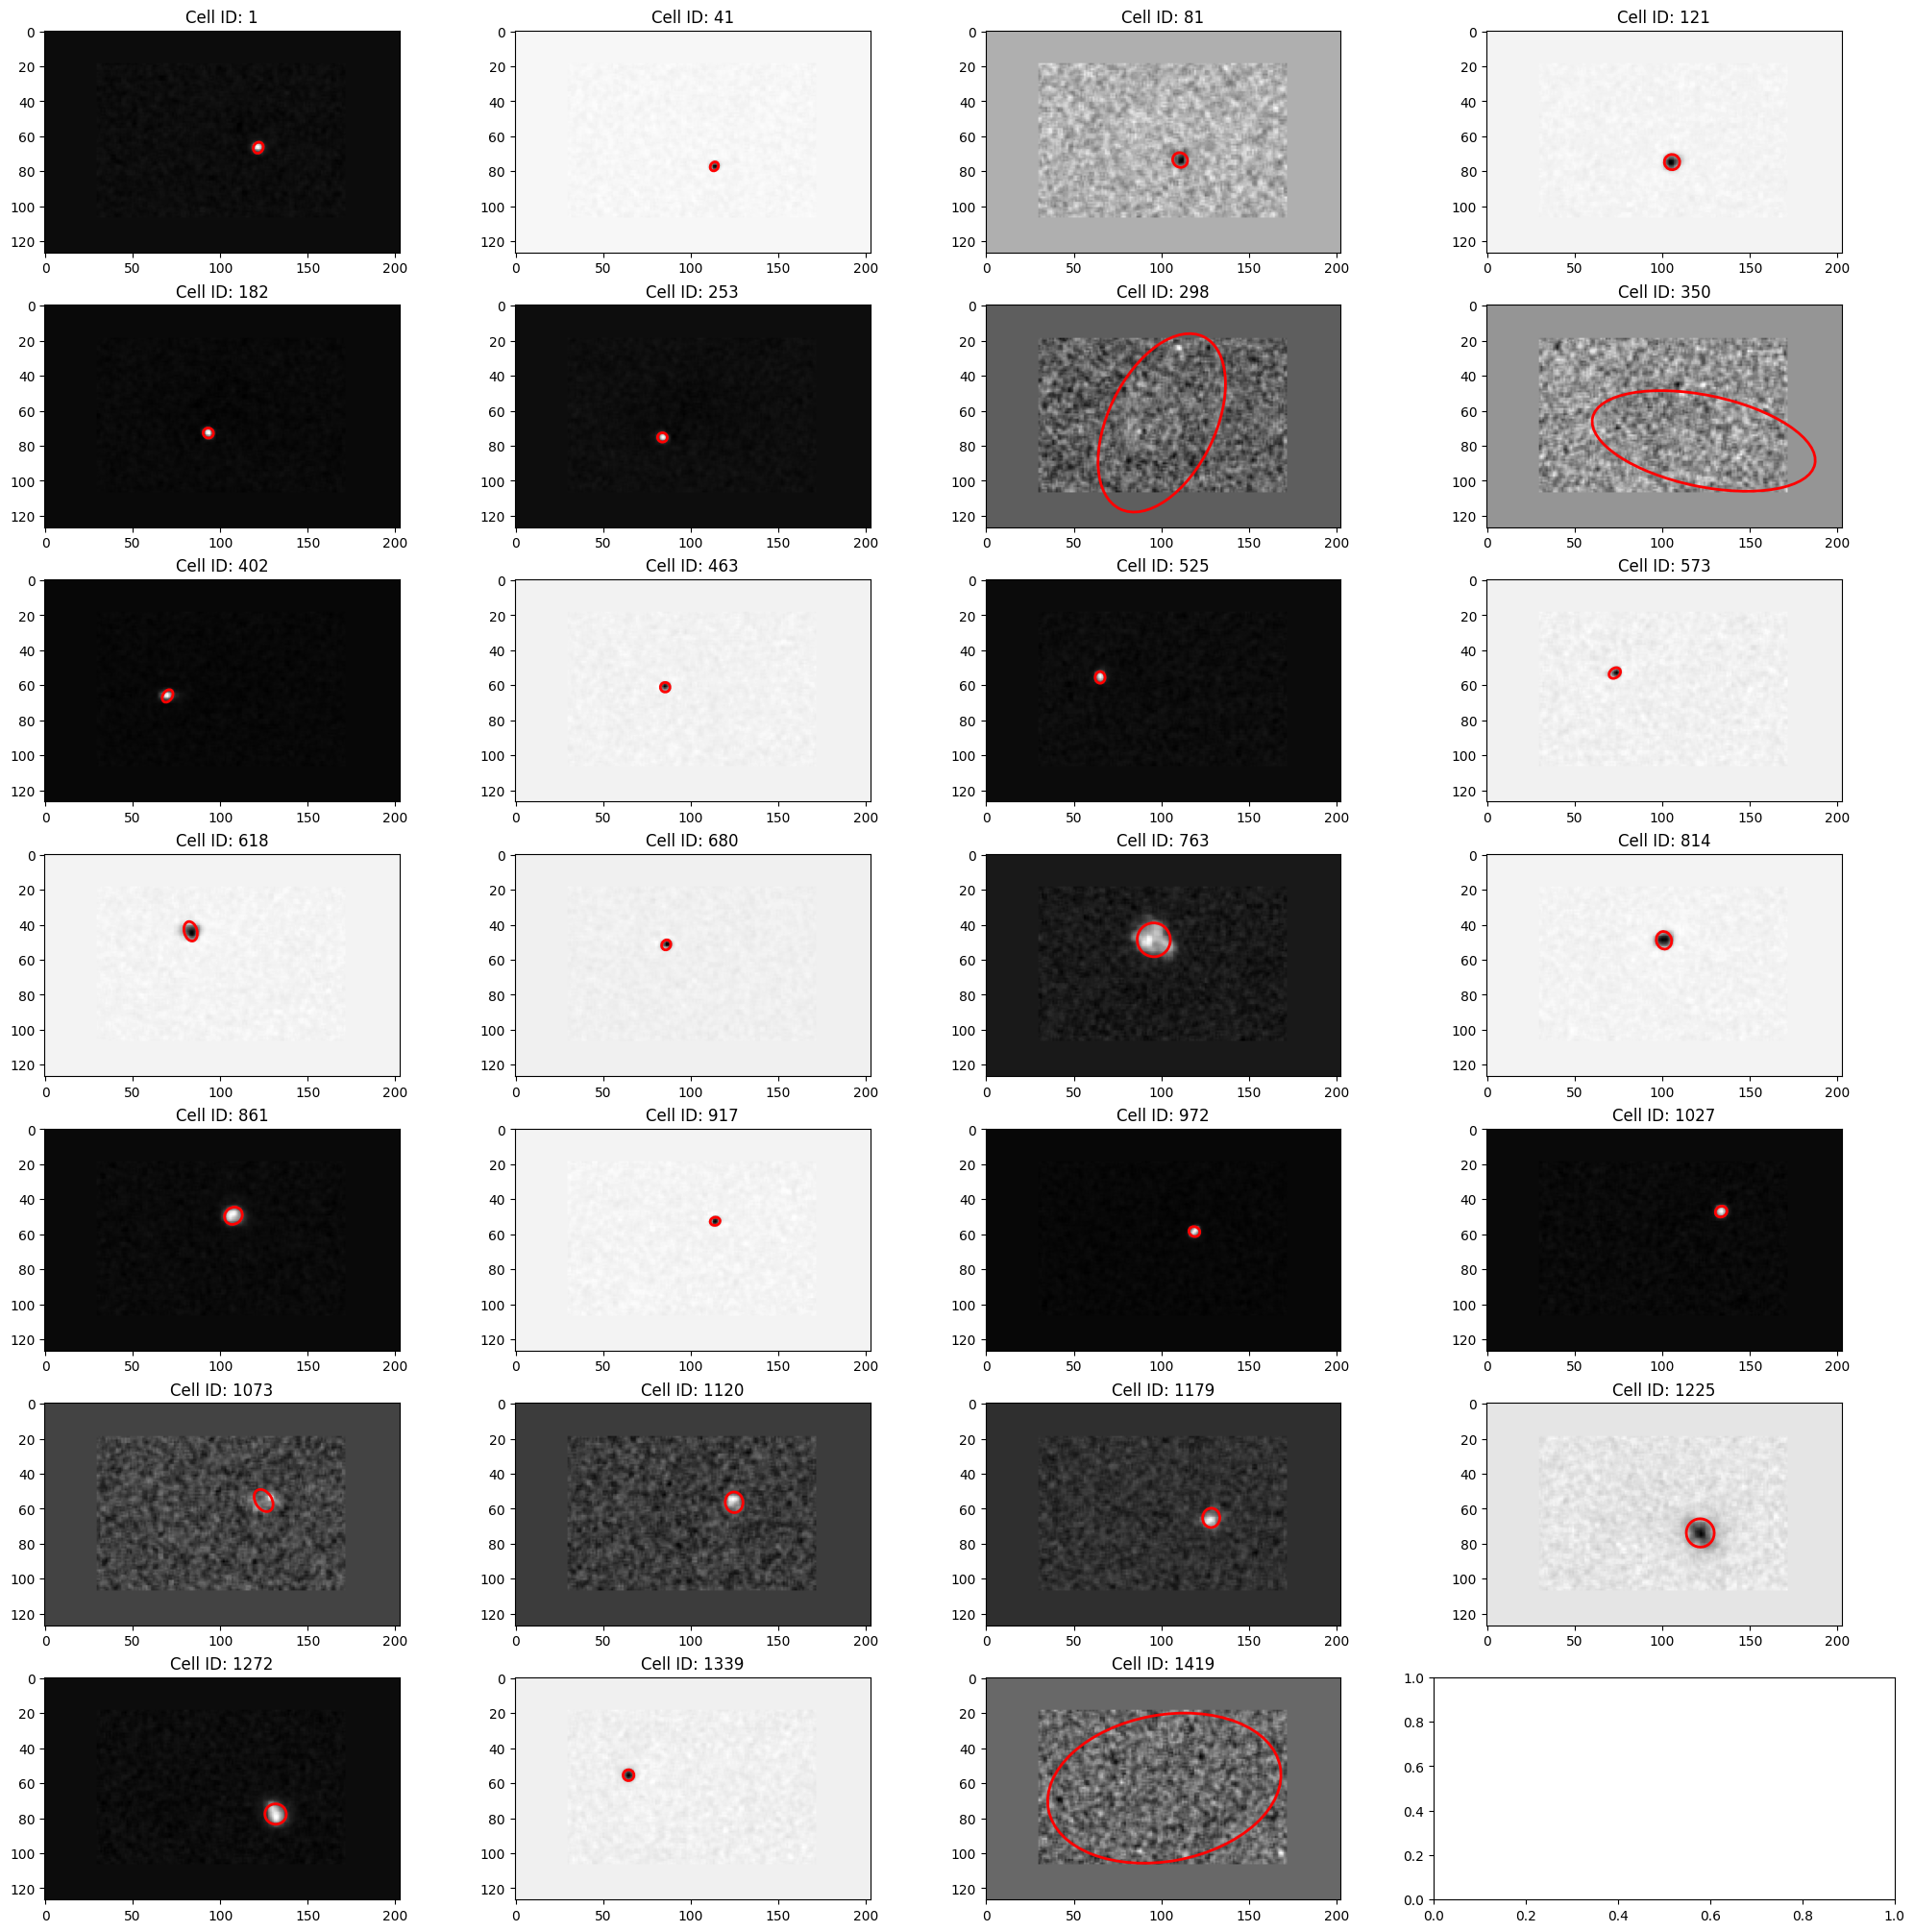

In [8]:
#confirmation that padding worked as expected

test_ids = ac.cell_ids[::30]
fig, ax = plt.subplots(int(np.ceil((len(test_ids)/4))), np.min([4, (len(test_ids)-1%4)+1]), figsize=(20, 20), constrained_layout=True)
ax= ax.flatten()
for idx, cell in enumerate(test_ids):
    ax[idx].imshow(ac.d_spatial_maps[cell][:,:,0], cmap='gray')
    subset = ac.df_cell_params[ac.df_cell_params['cell_id'] == cell]
    rf_params = [subset['center_x'].values[0],
                    subset['center_y'].values[0],
                    subset['std_x'].values[0],
                    subset['std_y'].values[0],
                    subset['rot'].values[0]]
    ellipse = Ellipse(xy=(rf_params[0], rf_params[1]),
                      width=rf_params[2]*2, height=rf_params[3]*2,
                      angle=np.rad2deg(rf_params[4]), 
                      edgecolor='red', facecolor='none', lw=2)
    ax[idx].add_patch(ellipse)
    ax[idx].set_title(f'Cell ID: {cell}')



In [19]:
sm_flat = [sm.flatten() for sm in ac.d_spatial_maps.values()]
sm_flat = np.array(sm_flat)

ei_flat = [ac.vcd.get_ei_for_cell(id).ei.flatten() for id in ac.cell_ids]
ei_flat = np.array(ei_flat)

sm_corr = np.corrcoef(sm_flat)
ei_corr = np.corrcoef(ei_flat)

np.nan_to_num(sm_corr, copy=False, nan = 0, posinf = 0, neginf = 0)
np.nan_to_num(ei_corr, copy=False, nan = 0, posinf = 0, neginf = 0);

/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


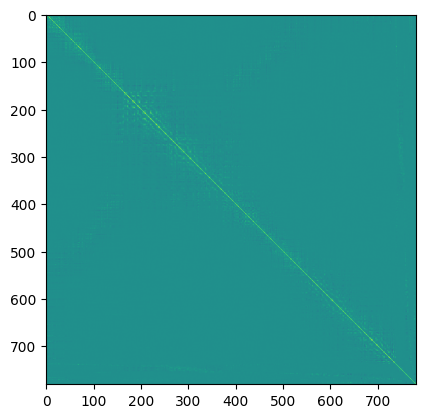

In [20]:
ei_corr = ra.ei_corr(ac, ac, method='full')
plt.imshow(ei_corr, cmap='viridis', vmin=-1, vmax=1)

In [28]:
cluster_to_index = dict(zip(ac.cell_ids, range(len(ac.cell_ids))))

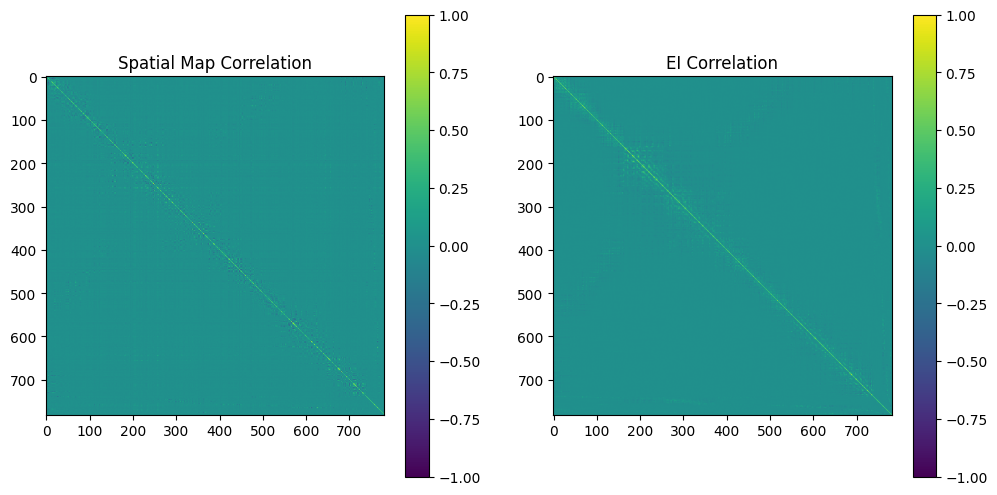

In [22]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
im = axs[0].imshow(sm_corr, cmap='viridis', vmin=-1, vmax=1)
axs[0].set_title('Spatial Map Correlation')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(ei_corr, cmap='viridis', vmin=-1, vmax=1)
axs[1].set_title('EI Correlation')
plt.colorbar(im, ax=axs[1])

number of high ei correlation pairs: 1
number of high spatial map correlation pairs: 25
intersection: 0


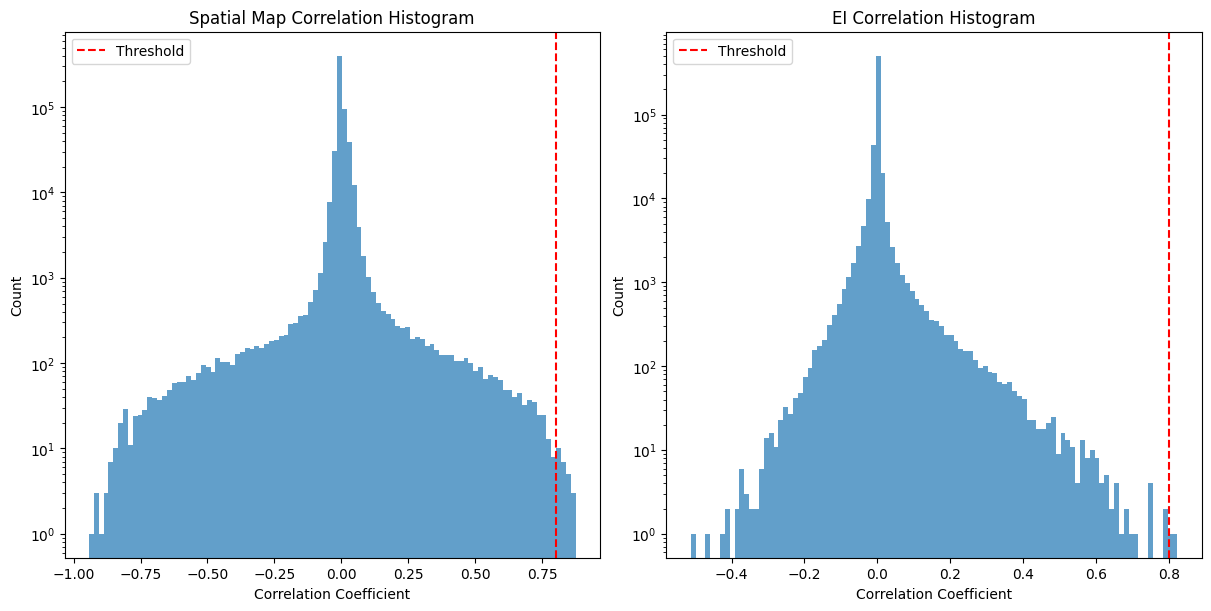

In [23]:
import copy
threshold_sm = 0.80
threshold_ei = 0.80

# Identify cells with high spatial map correlation
#remove self-correlations (diagonal of the correlation matrix)
sm_upper_tri = copy.deepcopy(sm_corr)
sm_upper_tri = np.triu(sm_upper_tri, k=1)  # Keep only upper triangle of the correlation matrix
high_sm_idx = np.where(sm_upper_tri > threshold_sm)
high_sm_corr_cells = set([(ac.cell_ids[high_sm_idx[0][i]], ac.cell_ids[high_sm_idx[1][i]]) for i in range(len(high_sm_idx[0]))]) # Get the indices of cells with high spatial map correlation
high_sm_idx_set = set([(high_sm_idx[0][i], high_sm_idx[1][i]) for i in range(len(high_sm_idx[0]))]) # Combine indices of both cells in the pair

ei_upper_tri = copy.deepcopy(ei_corr)
ei_upper_tri = np.triu(ei_upper_tri, k=1)  # Keep only upper triangle of the correlation matrix
high_ei_idx = np.where(ei_upper_tri > threshold_ei)
high_ei_corr_cells = set([(ac.cell_ids[high_ei_idx[0][i]], ac.cell_ids[high_ei_idx[1][i]]) for i in range(len(high_ei_idx[0]))]) # Get the indices of cells with high EI correlation
high_ei_idx_set = set([(high_ei_idx[0][i], high_ei_idx[1][i]) for i in range(len(high_ei_idx[0]))]) # Combine indices of both cells in the pair

# all_problem_cells = np.unique(np.array([ac.cell_ids[high_ei_idx[0][:]], ac.cell_ids[high_ei_idx[1][:]], ac.cell_ids[high_sm_idx[0][:]], ac.cell_ids[high_sm_idx[1][:]]]).flatten())

fig, ax = plt.subplots(1,2, figsize=(12, 6), constrained_layout=True)
ax[0].hist(sm_upper_tri.flatten(), bins=100, alpha=0.7)
ax[0].semilogy()
ax[0].set_title('Spatial Map Correlation Histogram')
ax[0].set_xlabel('Correlation Coefficient')
ax[0].set_ylabel('Count')
ax[1].hist(ei_upper_tri.flatten(), bins=100, alpha=0.7)
ax[1].semilogy()
ax[1].set_title('EI Correlation Histogram')
ax[1].set_xlabel('Correlation Coefficient')
ax[1].set_ylabel('Count')
ax[0].axvline(threshold_sm, color='red', linestyle='--', label='Threshold')
ax[1].axvline(threshold_ei, color='red', linestyle='--', label='Threshold')
ax[0].legend()
ax[1].legend()
print(f'number of high ei correlation pairs: {len(high_ei_corr_cells)}')
print(f'number of high spatial map correlation pairs: {len(high_sm_corr_cells)}')
print(f'intersection: {len(high_ei_corr_cells.intersection(high_sm_corr_cells))}')


In [24]:
#index ac.cell_ids by target clusters
all_problem_cells = {item for tuple in high_sm_corr_cells.union(high_ei_corr_cells) for item in tuple}
all_sm_cells = {item for tuple in high_sm_corr_cells for item in tuple}
all_ei_cells = {item for tuple in high_ei_corr_cells for item in tuple}

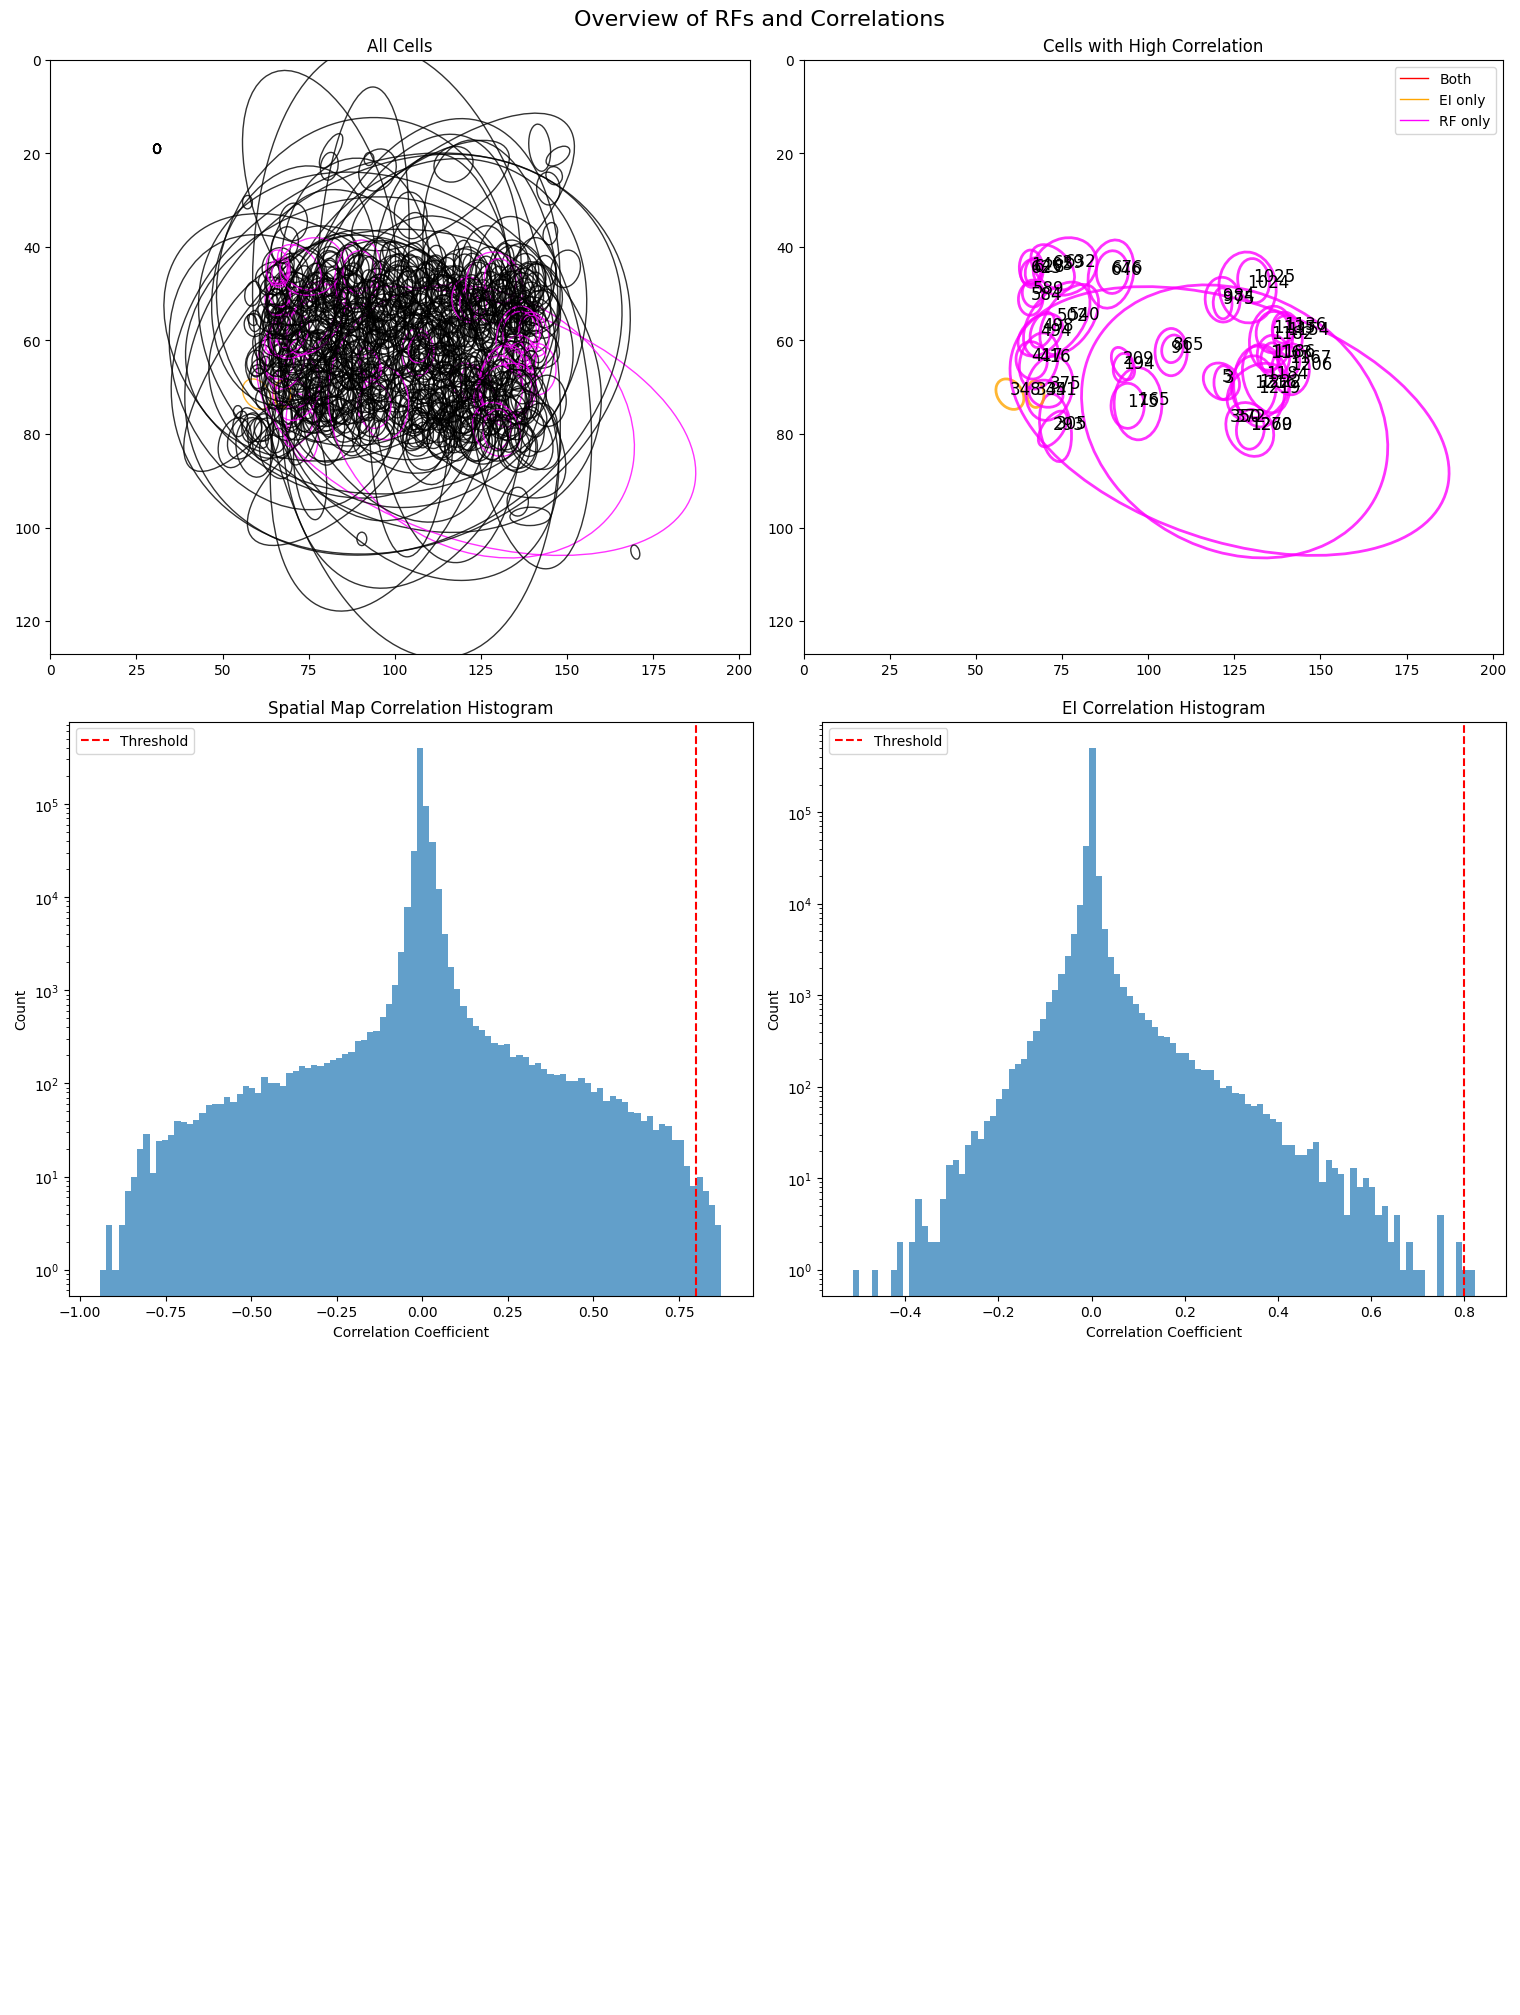

In [25]:
from matplotlib.lines import Line2D
rf_params = ac.rf_params
fig = plt.figure(figsize=(15, 20), layout='compressed')
fig.suptitle('Overview of RFs and Correlations', fontsize=16)
subfigs = fig.subfigures(3, 1) 
ax00 = subfigs[0].subplots(1, 2)
for cell in ac.cell_ids:
    ell1 = Ellipse(xy=(rf_params[cell]['center_x'], rf_params[cell]['center_y']),
                width=rf_params[cell]['std_x']*2, height=rf_params[cell]['std_y']*2,
                angle=np.rad2deg(rf_params[cell]['rot']), 
                edgecolor='None', facecolor='None', lw=2, alpha=0.8)
    if cell in all_ei_cells and cell in all_sm_cells:
        ell1.set_edgecolor('red')
        color = 'red'
        ax00[1].add_patch(ell1)
        ax00[1].annotate(f'{cell}', xy=(rf_params[cell]['center_x'], rf_params[cell]['center_y']), fontsize=12)
    elif cell in all_ei_cells:
        ell1.set_edgecolor('orange')
        color = 'orange'
        ax00[1].add_patch(ell1)
        ax00[1].annotate(f'{cell}', xy=(rf_params[cell]['center_x'], rf_params[cell]['center_y']), fontsize=12)
    elif cell in all_sm_cells:
        ell1.set_edgecolor('magenta')
        color = 'magenta'
        ax00[1].add_patch(ell1)
        ax00[1].annotate(f'{cell}', xy=(rf_params[cell]['center_x'], rf_params[cell]['center_y']), fontsize=12)
    else:
        color = 'black'
    ell = Ellipse(xy=(rf_params[cell]['center_x'], rf_params[cell]['center_y']),
                  width=rf_params[cell]['std_x']*2, height=rf_params[cell]['std_y']*2,
                  angle=np.rad2deg(rf_params[cell]['rot']), 
                  edgecolor=color, facecolor='None', lw=1, alpha=0.8)
    ax00[0].add_patch(ell)
ax00[0].set_xlim(0, ac.numXChecks)
ax00[0].set_ylim(ac.numYChecks, 0) 
ax00[1].set_xlim(0, ac.numXChecks)
ax00[1].set_ylim(ac.numYChecks, 0)  # Invert y-axis to match spatial map orientation
ax00[0].set_title('All Cells')
ax00[1].set_title('Cells with High Correlation')
custom_lines = [Line2D([0], [0], color='red', lw=1, label='Both'),
                    Line2D([0], [0], color='orange', lw=1, label='EI only'),
                    Line2D([0], [0], color='magenta', lw=1, label='RF only')]
ax00[1].legend(handles=custom_lines, loc='upper right')

ax01 = subfigs[1].subplots(1, 2)
ax01[0].hist(sm_upper_tri.flatten(), bins=100, alpha=0.7)
ax01[0].semilogy()
ax01[0].set_title('Spatial Map Correlation Histogram')
ax01[0].set_xlabel('Correlation Coefficient')
ax01[0].set_ylabel('Count')
ax01[1].hist(ei_upper_tri.flatten(), bins=100, alpha=0.7)
ax01[1].semilogy()
ax01[1].set_title('EI Correlation Histogram')
ax01[1].set_xlabel('Correlation Coefficient')
ax01[1].set_ylabel('Count')
ax01[0].axvline(threshold_sm, color='red', linestyle='--', label='Threshold')
ax01[1].axvline(threshold_ei, color='red', linestyle='--', label='Threshold')
ax01[0].legend()
ax01[1].legend()


In [26]:
high_ei_corr_cells

{(344, 348)}

In [27]:
high_sm_corr_cells

{(3, 5),
 (91, 865),
 (165, 175),
 (194, 209),
 (293, 305),
 (350, 372),
 (351, 375),
 (416, 417),
 (494, 498),
 (502, 540),
 (584, 589),
 (625, 628),
 (625, 1405),
 (629, 632),
 (646, 676),
 (975, 984),
 (1024, 1025),
 (1135, 1182),
 (1136, 1154),
 (1163, 1186),
 (1167, 1206),
 (1184, 1222),
 (1216, 1222),
 (1219, 1222),
 (1269, 1270)}

/var/folders/fh/0bf2w4wj0x35lmp08kv35ylc0000gn/T/ipykernel_35577/319313472.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


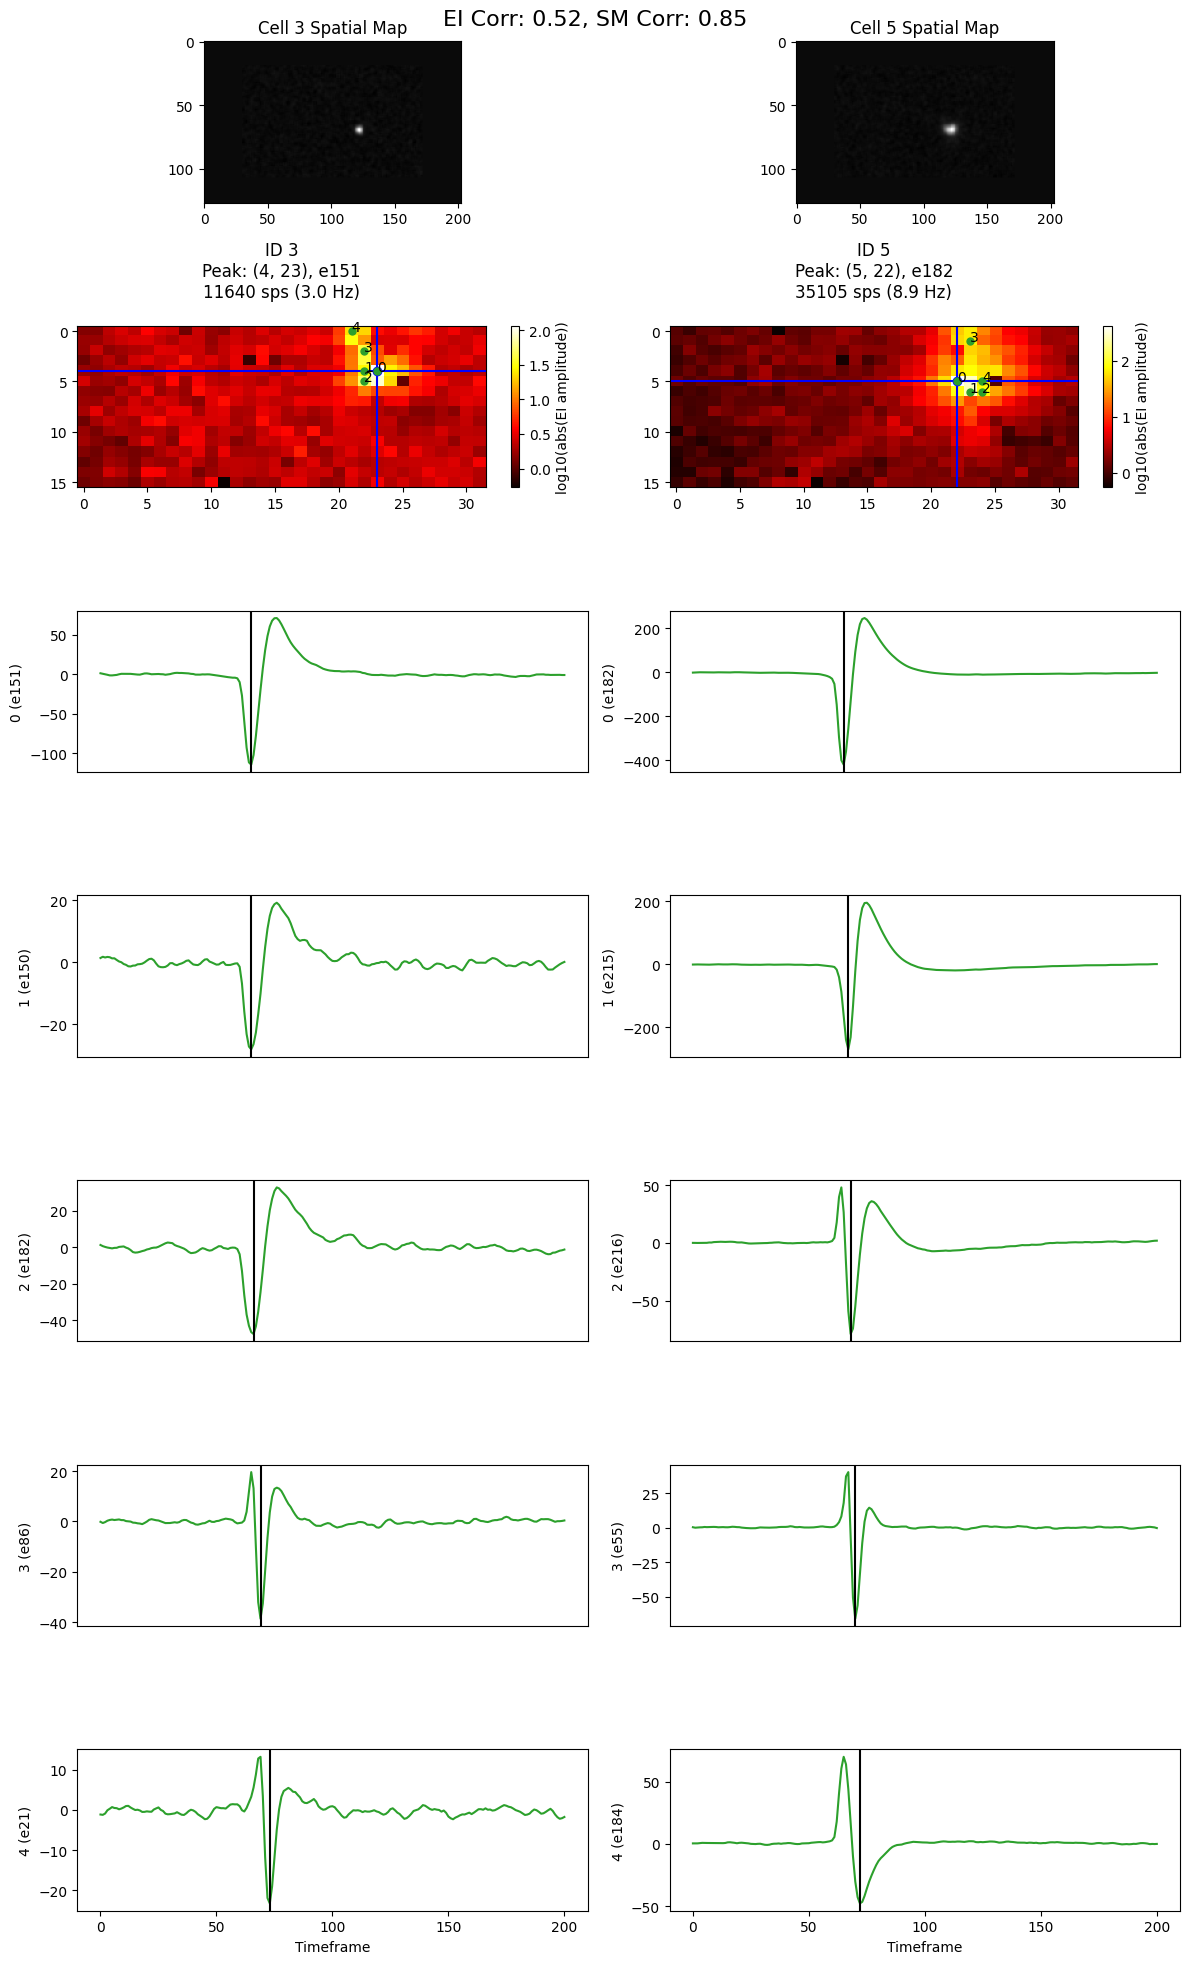

In [41]:
cell_a = 3
cell_b = 5

ei_1 = ac.vcd.get_ei_for_cell(cell_a).ei
ei_2 = ac.vcd.get_ei_for_cell(cell_b).ei
sorted_electrodes = ra.sort_electrode_map(ac.vcd.get_electrode_map())
e1_1 = ra.reshape_ei(ei_1, sorted_electrodes)
e1_2 = ra.reshape_ei(ei_2, sorted_electrodes)
e1_1 = np.log10(np.max(np.abs(e1_1), axis=2)+1e-6)
e1_2 = np.log10(np.max(np.abs(e1_2), axis=2)+1e-6)

fig, ax = plt.subplots(7, 2, figsize=(12, 20))
im1=ax[0,0].imshow(ac.d_spatial_maps[cell_a][:,:,0], cmap='gray')
im2=ax[0,1].imshow(ac.d_spatial_maps[cell_b][:,:,0], cmap='gray')
ax[0,0].set_title(f'Cell {cell_a} Spatial Map')
ax[0,1].set_title(f'Cell {cell_b} Spatial Map')
# im3=ax[1,0].imshow(e1_1, cmap='hot')
# im4=ax[1,1].imshow(e1_2, cmap='hot')
# ax[1,0].set_title(f'Cell {cell_a} EI')
# ax[1,1].set_title(f'Cell {cell_b} EI')
ax1 = ra.ei_utils.plot_ei_map(cell_a, ac.vcd, axs=ax[1:,0])
ax2 = ra.ei_utils.plot_ei_map(cell_b, ac.vcd, axs=ax[1:,1])
# plt.colorbar(im1, ax=ax[0,0])
# plt.colorbar(im2, ax=ax[0,1])
# plt.colorbar(im3, ax=ax[1,0])
# plt.colorbar(im4, ax=ax[1,1])
fig.suptitle(f'EI Corr: {ei_corr[cluster_to_index[cell_a], cluster_to_index[cell_b]]:.2f}, SM Corr: {sm_corr[cluster_to_index[cell_a], cluster_to_index[cell_b]]:.2f}', fontsize=16)
plt.tight_layout()

<Axes: title={'center': 'ID 3\nPeak: (4, 23), e151\n11640 sps (3.0 Hz)\n'}>

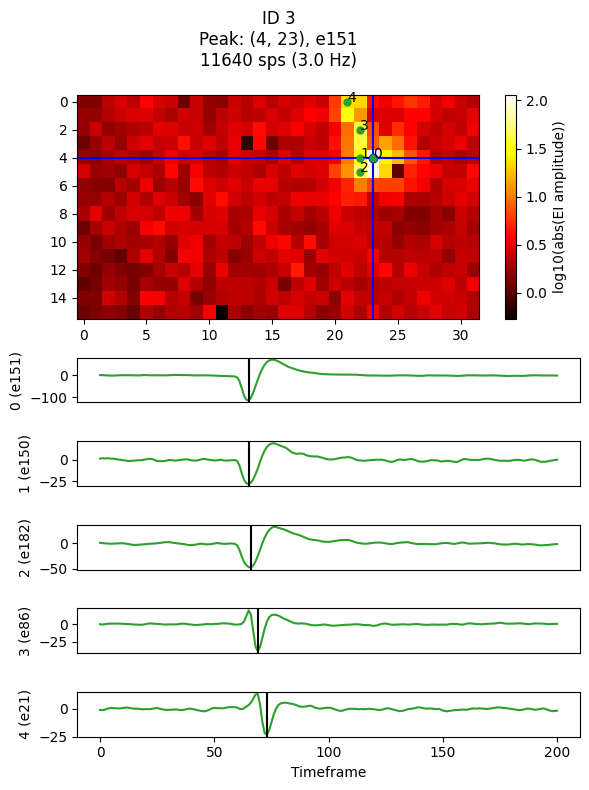

In [26]:
ra.ei_utils.plot_ei_map(cell_a, ac.vcd)

In [29]:
ac

AnalysisChunk with properties:
  exp_name: 20250514C
  chunk_name: chunk1
  ss_version: kilosort2.5
  noise_protocol: manookinlab.protocols.SpatialNoise
  data_files: ['data000', 'data001']
  typing_files: ['dragos_kilosort2.5.classification.txt']
  numXChecks: 203
  numYChecks: 127
  staXChecks: 142
  staYChecks: 88
  canvas_size: [1824, 1140]
  microns_per_pixel: 3.37
  cell_ids of length: 781
  rf_params with fiels: ['center_x', 'center_y', 'std_x', 'std_y', 'rot']
  df_cell_params of shape: (781, 7)
  d_spatial_maps with 781 cells

In [3]:
amps = np.load('/Volumes/data/data/sorted/20250514C/chunk1/kilosort2.5/amplitudes.npy')
templates = np.load('/Volumes/data/data/sorted/20250514C/chunk1/kilosort2.5/spike_templates.npy')

In [2]:
spike_times = np.load('/Volumes/data/data/sorted/20250514C/chunk1/kilosort2.5/spike_times.npy')
print(spike_times.shape)

(27979591, 1)


In [25]:
pc_templates = np.load('/Volumes/data/data/sorted/20250429C/chunk1/kilosort2.5/pc_features.npy',mmap_mode='r')

In [26]:
pc_feature_inds = np.load('/Volumes/data/data/sorted/20250429C/chunk1/kilosort2.5/pc_feature_ind.npy')
spike_templ = np.load('/Volumes/data/data/sorted/20250429C/chunk1/kilosort2.5/spike_templates.npy')
spike_times = np.load('/Volumes/data/data/sorted/20250429C/chunk1/kilosort2.5/spike_times.npy')

In [35]:
cluster_id_a = 199-1
cluster_id_b = 212-1

spike_indx_a = np.where(spike_templ == cluster_id_a)[0]
spike_indx_b = np.where(spike_templ == cluster_id_b)[0]

feat_chan_ids_a = pc_feature_inds[cluster_id_a, :].astype(int)
feat_chan_ids_b = pc_feature_inds[cluster_id_b, :].astype(int)


In [36]:
chan_0_a = feat_chan_ids_a[0]
chan_0_b = feat_chan_ids_b[0]

chan_1_a = feat_chan_ids_a[1]
chan_1_b = feat_chan_ids_b[1]

times_spikes_a = spike_times[spike_indx_a]
times_spikes_b = spike_times[spike_indx_b]

num_chan_pc_combos = 2*2

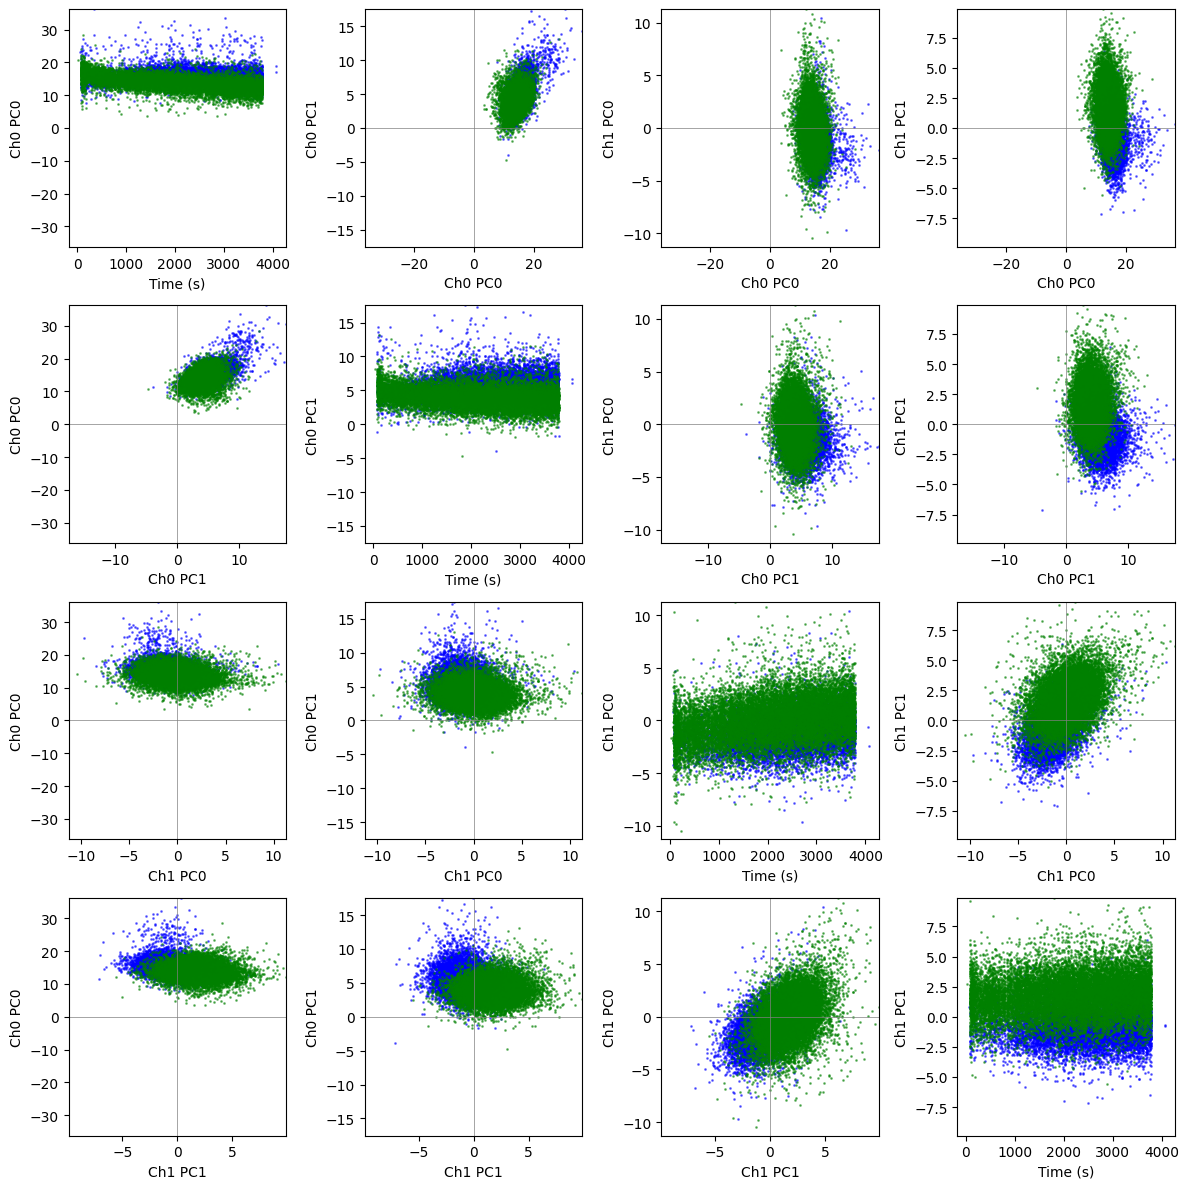

In [37]:
fig, axs = plt.subplots(4, 4, figsize=(12,12))
for i in range(num_chan_pc_combos):
    for j in range(num_chan_pc_combos):
        ax = axs[i, j]
        if i == j:
            x_a = times_spikes_a / 20000
            y_a = pc_templates[spike_indx_a, i%2, i//2] 
            ax.set_xlabel(f'Time (s)')
            ax.set_ylabel(f'Ch{i//2} PC{i%2}')

            x_b = times_spikes_b / 20000
            y_b = pc_templates[spike_indx_b, j%2, j//2]


        else:
            x_a = pc_templates[spike_indx_a, i%2, i//2]
            y_a = pc_templates[spike_indx_a, j%2, j//2]

            x_b = pc_templates[spike_indx_b, i%2, i//2]
            y_b = pc_templates[spike_indx_b, j%2, j//2]

            ax.set_xlabel(f'Ch{i//2} PC{i%2}')
            ax.set_ylabel(f'Ch{j//2} PC{j%2}')
            x_max_a = np.max(np.abs(x_a))

            x_max_b = np.max(np.abs(x_b))
            ax.set_xlim(min(-x_max_a, -x_max_b), max(x_max_a, x_max_b))

            ax.axhline(0, color='gray', linewidth=0.5)
            ax.axvline(0, color='gray', linewidth=0.5)

        y_max_a = np.max(np.abs(y_a))
        y_max_b = np.max(np.abs(y_b))

        ax.set_ylim(min(-y_max_a, -y_max_b), max(y_max_a, y_max_b))
        ax.scatter(x_a, y_a, s=1, alpha=0.5, color='blue', label=f'Cell {cluster_id_a}')
        ax.scatter(x_b, y_b, s=1, alpha=0.5, color='green', label=f'Cell {cluster_id_b}')
plt.tight_layout()


In [14]:
pc_templates[spike_indx_a, i%2, i//2] 

array([], dtype=float32)

In [17]:
cluster_id_a

199

In [4]:
templates_vision = templates + 1
amplitudes = np.vstack((np.squeeze(amps), np.squeeze(templates_vision)))


In [82]:
a = amplitudes[:,amplitudes[1,:]==cell_a]
print(a.shape)

(2, 11640)


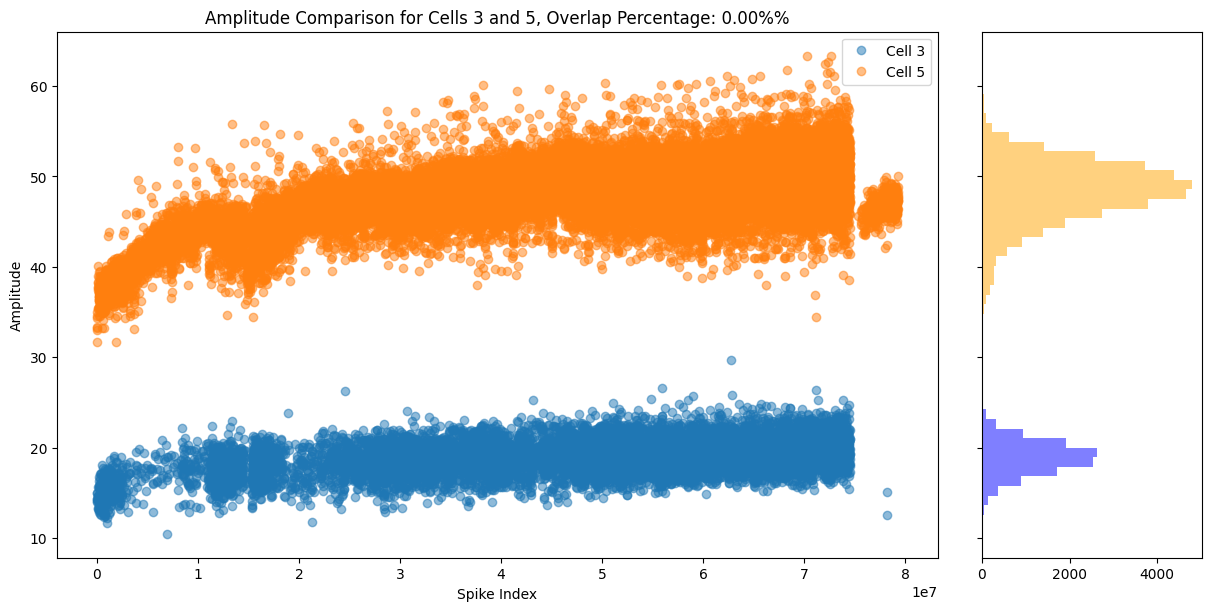

In [8]:
cell_a = 3
cell_b = 5
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
amps1 = amplitudes[0,amplitudes[1,:]==cell_a]
times1 = spike_times[amplitudes[1,:]==cell_a]
amps2 = amplitudes[0,amplitudes[1,:]==cell_b]
times2 = spike_times[amplitudes[1,:]==cell_b]
ax.plot(times1,amps1, 'o', label=f'Cell {cell_a}', alpha=0.5)
ax.plot(times2,amps2, 'o', label=f'Cell {cell_b}', alpha=0.5)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
ax_histy.tick_params(axis='y',labelleft=False)

min_val = min(np.min(amps1), np.min(amps2))
max_val = max(np.max(amps1), np.max(amps2))

num_bins = 50
bin_edges = np.linspace(min_val, max_val, num_bins + 1)
hist1, _ = np.histogram(amps1, bins=bin_edges)
hist2, _ = np.histogram(amps2, bins=bin_edges)

ax_histy.stairs(hist1, bin_edges, fill=True, alpha=0.5, color='blue', orientation='horizontal', label=f'Cell {cell_a}')
ax_histy.stairs(hist2, bin_edges, fill=True, alpha=0.5, color='orange', orientation='horizontal', label=f'Cell {cell_b}')

intersection = np.sum(np.minimum(hist1, hist2))
total_sum_hist1 = np.sum(hist1)
overlap_fraction = intersection / total_sum_hist1 if total_sum_hist1 > 0 else 0

ax.set_xlabel('Spike Index')
ax.set_ylabel('Amplitude')
ax.set_title(f'Amplitude Comparison for Cells {cell_a} and {cell_b}, Overlap Percentage: {overlap_fraction*100:.2%}%')
ax.legend()

In [138]:
index = np.where(amplitudes[1,:] == cell_a)[0]
templates[index]

array([[164],
       [164],
       [164],
       ...,
       [164],
       [164],
       [164]], dtype=uint32)

In [140]:
import retinanalysis.dedup as dd
importlib.reload(dd)

# ei_autocorr, high_ei_pairs = dd.get_ei_autocorrelation(ac)
# print(ei_autocorr.all() == ei_corr.all())
# print(high_ei_pairs.difference(high_ei_corr_cells))

<module 'retinanalysis.dedup' from '/Users/racheloaks-leaf/Desktop/retinanalysis/src/retinanalysis/dedup.py'>

In [39]:
pcs, ei_pcs, sm_pcs = dd.isolate_problem_cells(block=ac)
# print(pcs.difference(all_problem_cells))
# print(ei_pcs.difference(all_problem_cells))
# print(sm_pcs.difference(all_problem_cells))

/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


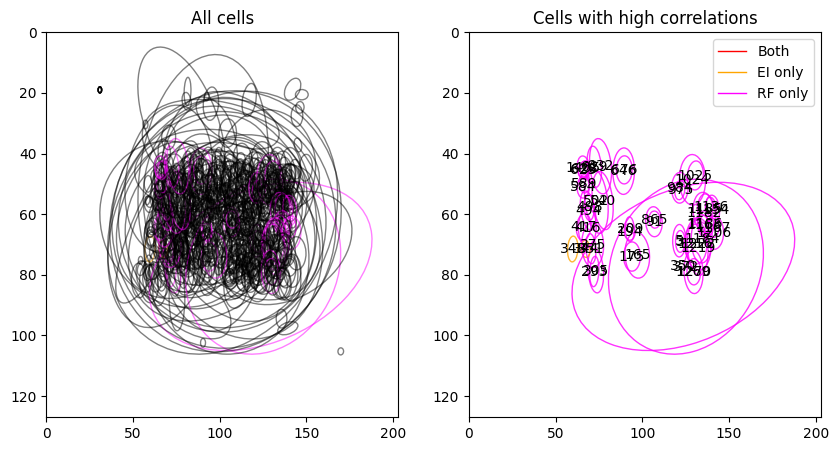

In [12]:
fig, ax = dd.plotRFs_dedup(ac)

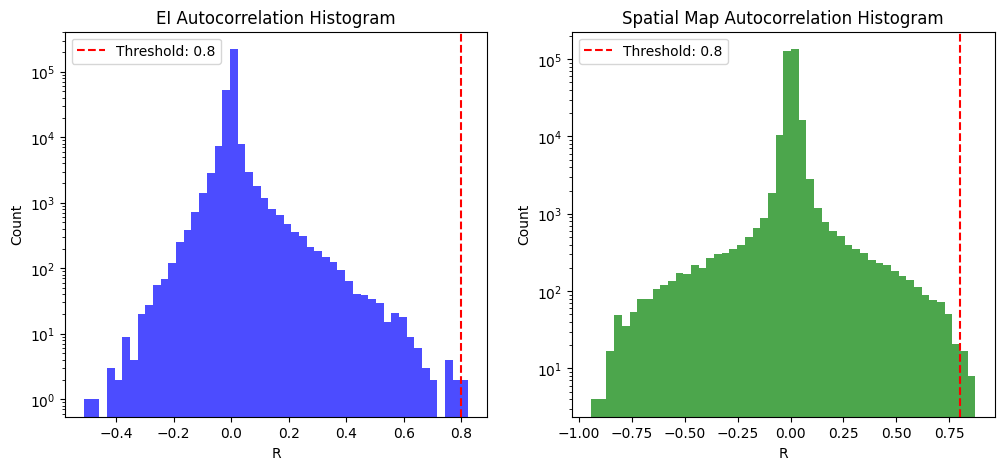

In [13]:
fig, ax = dd.plot_histograms(ac)

In [14]:
#now using ei and sm pairs, generate a set of groups that are connected by either ei or sm correlation
ei_corr, high_ei_pairs = dd.get_ei_autocorrelation(ac)
sm_corr, high_sm_pairs = dd.get_sm_autocorrelation(ac)

/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [22]:
pairs_dict = {}
for a, b in high_sm_pairs:
    if a not in pairs_dict:
        pairs_dict[a] = set()
    if b not in pairs_dict:
        pairs_dict[b] = set()
    pairs_dict[a].add(b)
    pairs_dict[b].add(a)

extended = set()
for origin in high_sm_pairs:
    a, b = origin

    paired_w_a = pairs_dict.get(a, set())
    paired_w_b = pairs_dict.get(b, set())
    all_paired = paired_w_a.union(paired_w_b)
    all_paired_tuple = tuple(sorted(all_paired))
    extended.add(all_paired_tuple)

ext_test = dd.generate_extended_pairings(high_sm_pairs)
print(ext_test == extended)




True


In [132]:
ext_1 = dd.generate_extended_pairings(high_sm_pairs)
ext_2 = dd.generate_extended_pairings(high_ei_pairs)
ext_all = ext_1.union(ext_2)

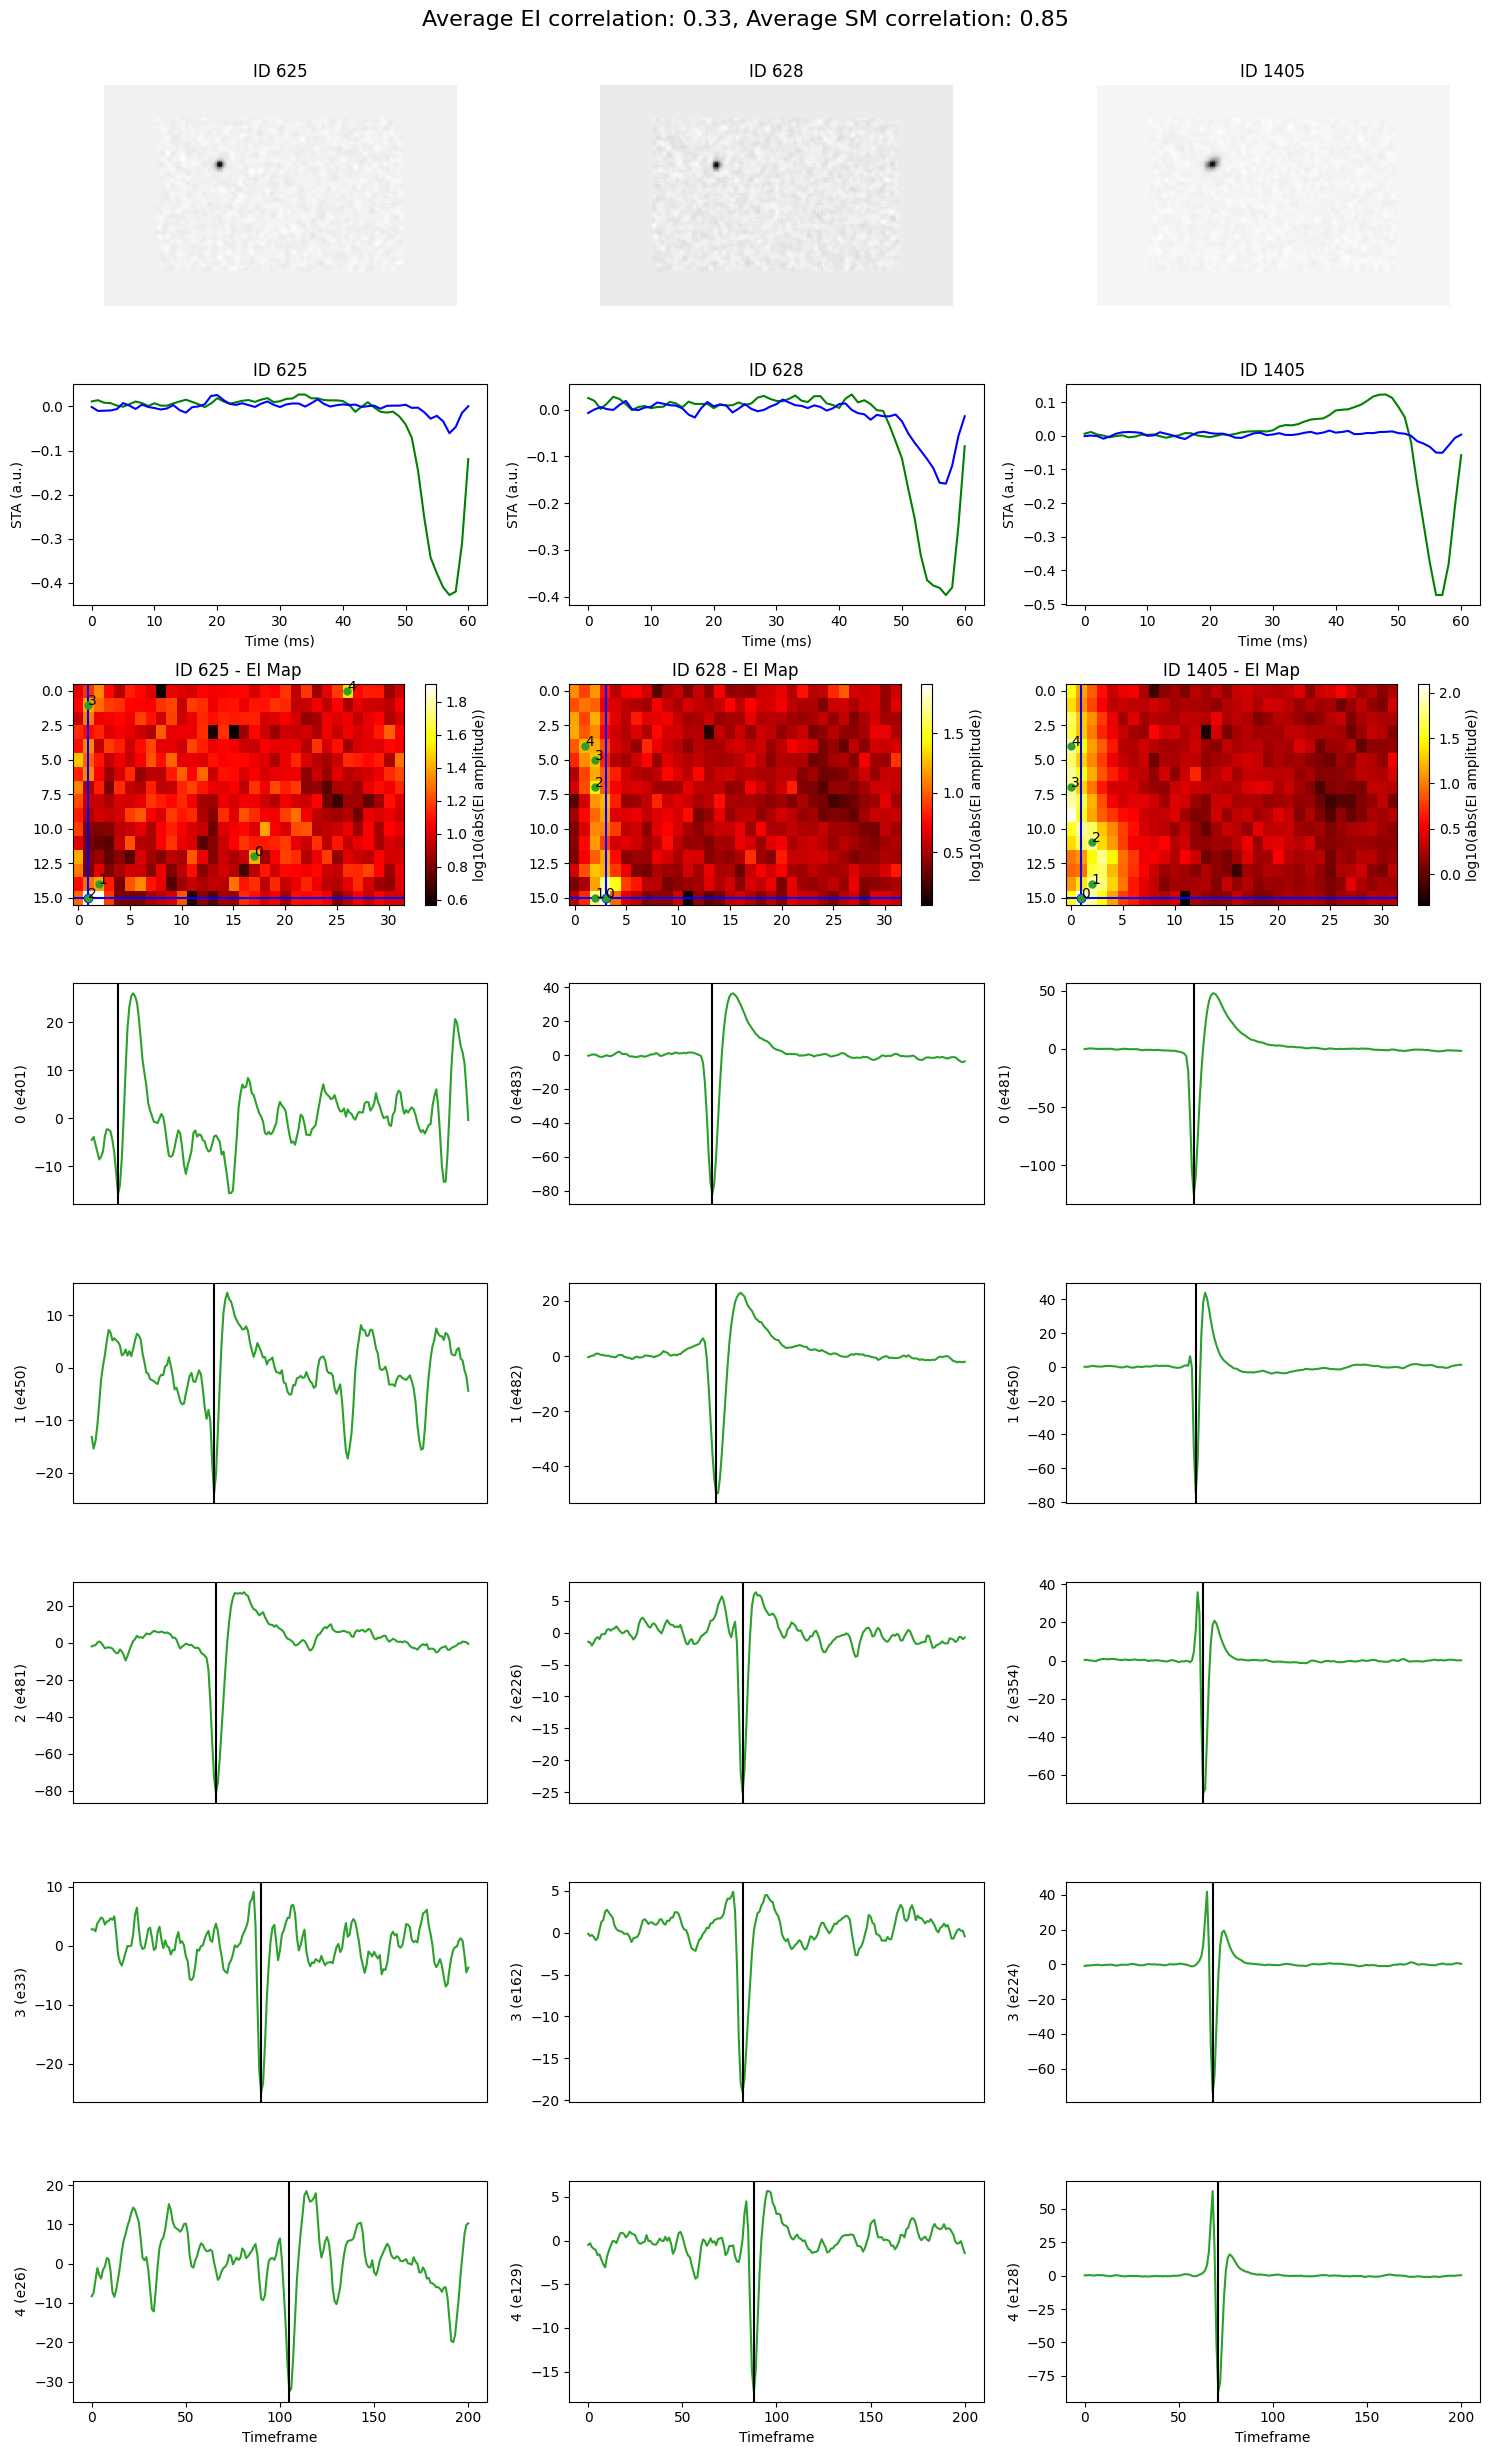

In [77]:
group = (625, 628, 1405)
dd.visualize_groups(group, ac, detailed=True);

<Axes: xlabel='Spike index', ylabel='Amplitude'>

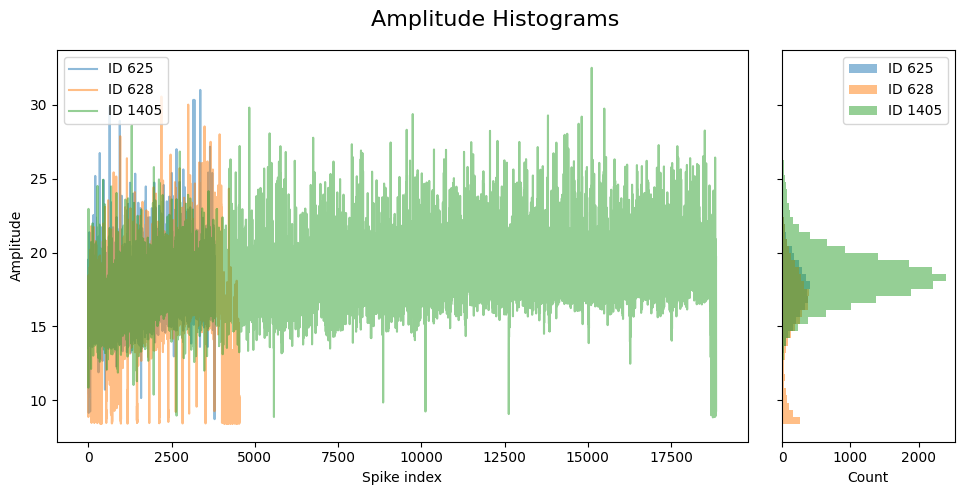

In [99]:
dd.plot_amplitude_histograms(amplitudes, templates, group)

In [109]:
all_pairs = high_sm_pairs.union(high_ei_pairs)
# for a, b in all_pairs:


In [113]:
ext_test

{(3, 5),
 (91, 865),
 (165, 175),
 (194, 209),
 (293, 305),
 (350, 372),
 (351, 375),
 (416, 417),
 (494, 498),
 (502, 540),
 (584, 589),
 (625, 628, 1405),
 (629, 632),
 (646, 676),
 (975, 984),
 (1024, 1025),
 (1135, 1182),
 (1136, 1154),
 (1163, 1186),
 (1167, 1206),
 (1184, 1216, 1219, 1222),
 (1269, 1270)}

In [133]:
#now, we want to set up a df to summarize the results of the deduplication process for each pair
#not group, since most metrics are pairwise
from itertools import combinations

header = ['cell_a', 'cell_b', 'sm_corr', 'ei_corr']
stats = []
#columns are: cella, cellb, sm_corr(if available), ei_corr, amplitude histogram overlap fraction
for tup in ext_all:
    group = np.array(tup)
    pairs = list(combinations(group, 2))
    for a, b in pairs:
        cell_a = a
        cell_b = b
        sm_corr_val = sm_corr[cluster_to_index[cell_a], cluster_to_index[cell_b]]
        ei_corr_val = ei_corr[cluster_to_index[cell_a], cluster_to_index[cell_b]]
        stats.append([cell_a, cell_b, sm_corr_val, ei_corr_val])

df_stats = pd.DataFrame(stats, columns=header)
df_stats




cell_a  cell_b   sm_corr   ei_corr
0     1269    1270  0.816738  0.348074
1     1163    1186  0.828902  0.043745
2      494     498  0.873968  0.116579
3      194     209  0.865273  0.122961
4      502     540  0.813196 -0.063899
5      293     305  0.821261 -0.138267
6     1135    1182  0.802637 -0.163066
7      416     417  0.840111  0.257768
8        3       5  0.853526  0.521849
9      975     984  0.811850  0.052006
10    1167    1206  0.803321 -0.154123
11     646     676  0.802221  0.004372
12     584     589  0.829547 -0.061545
13     625     628  0.807710  0.048340
14     625    1405  0.849013 -0.026668
15     628    1405  0.679455 -0.053396
16     344     348  0.066458  0.823695
17     350     372  0.839123  0.371169
18      91     865  0.829180  0.071473
19     629     632  0.838546  0.103786
20     351     375  0.815873  0.271857
21    1024    1025  0.805337  0.251664
22    1184    1216  0.689419  0.289994
23    1184    1219  0.678921  0.302582
24    1184    1222  0.863647  0.218083
25    1216    1219  0.793003  0.304190
26    1216    1222  0.827605  0.089565
27    1219    1222  0.811662  0.458905
28    1136    1154  0.826615  0.092777
29     165     175  0.830937  0.090422

In [141]:
summary_stats = dd.get_summary_stats(ac, amplitudes)
summary_stats

/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


cluster_a  cluster_b   ei_corr   sm_corr  overlap_fraction
0        1269       1270  0.348074  0.816738          0.000080
1         494        498  0.116579  0.873968          0.001114
2         194        209  0.122961  0.865273          0.817409
3         416        417  0.257768  0.840111          0.708154
4         975        984  0.052006  0.811850          0.048356
5        1167       1206 -0.154123  0.803321          0.010805
6         625        628  0.048340  0.807710          0.900132
7         625       1405 -0.026668  0.849013          0.994993
8         628       1405 -0.053396  0.679455          0.819943
9         344        348  0.823695  0.066458          0.407436
10        351        375  0.271857  0.815873          0.025420
11       1024       1025  0.251664  0.805337          0.438685
12       1136       1154  0.092777  0.826615          0.018828
13        165        175  0.090422  0.830937          0.244717
14        584        589 -0.061545  0.829547          0.000000
15       1163       1186  0.043745  0.828902          0.177776
16        502        540 -0.063899  0.813196          0.996759
17        293        305 -0.138267  0.821261          0.016622
18       1135       1182 -0.163066  0.802637          0.006445
19          3          5  0.521849  0.853526          0.000000
20        646        676  0.004372  0.802221          0.004438
21        350        372  0.371169  0.839123          0.880064
22         91        865  0.071473  0.829180          0.024636
23        629        632  0.103786  0.838546          0.347996
24       1184       1216  0.289994  0.689419          0.068218
25       1184       1219  0.302582  0.678921          0.125745
26       1184       1222  0.218083  0.863647          0.073171
27       1216       1219  0.304190  0.793003          0.968238
28       1216       1222  0.089565  0.827605          0.997157
29       1219       1222  0.458905  0.811662          0.754335